In [ ]:
# install kaggle first:
import os
!pip install kaggle
# set your Kaggle API key:
os.environ['KAGGLE_USERNAME'] = "haifanisardesai"
os.environ['KAGGLE_KEY'] = "2d946a88a042a953cab3d21e0324260c"
# then download:
!kaggle datasets download -d jessicali9530/celeba-dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip "/content/celeba-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [ ]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class CelebA():
  def __init__(self, main_folder='/content/', selected_features=None, drop_features=[]):
    self.main_folder = main_folder
    self.images_folder   = os.path.join(main_folder, 'img_align_celeba/img_align_celeba')
    self.attributes_path = os.path.join(main_folder, 'list_attr_celeba.csv')
    self.partition_path  = os.path.join(main_folder, 'list_eval_partition.csv')
    self.selected_features = selected_features
    self.features_name = []
    self.__prepare(drop_features)

  def __prepare(self, drop_features):
    # attributes:
    if self.selected_features is None:
      self.attributes = pd.read_csv(self.attributes_path)
      self.num_features = 40
    else:
      self.num_features = len(self.selected_features)
      self.selected_features = self.selected_features.copy()
      self.selected_features.append('image_id')
      self.attributes = pd.read_csv(self.attributes_path)[self.selected_features]

    # remove unwanted features:
    for feature in drop_features:
      if feature in self.attributes:
        self.attributes = self.attributes.drop(feature, axis=1)
        self.num_features -= 1

    self.attributes.set_index('image_id', inplace=True)
    self.attributes.replace(to_replace=-1, value=0, inplace=True)
    self.attributes['image_id'] = list(self.attributes.index)

    self.features_name = list(self.attributes.columns)[:-1]

    # load ideal partitioning:
    self.partition = pd.read_csv(self.partition_path)
    self.partition.set_index('image_id', inplace=True)

  def split(self, name='training', drop_zero=False):
    '''Returns the ['training', 'validation', 'test'] split of the dataset'''
    # select partition split:
    if name == 'training':
      to_drop = self.partition.where(lambda x: x != 0).dropna()
    elif name == 'validation':
      to_drop = self.partition.where(lambda x: x != 1).dropna()
    elif name == 'test':  # test
      to_drop = self.partition.where(lambda x: x != 2).dropna()
    else:
      raise ValueError('CelebA.split() => `name` must be one of [training, validation, test]')

    partition = self.partition.drop(index=to_drop.index)

    # join attributes with selected partition:
    joint = partition.join(self.attributes, how='inner').drop('partition', axis=1)

    if drop_zero == True:
      # select rows with all zeros values
      return joint.loc[(joint[self.features_name] == 1).any(axis=1)]
    elif 0 <= drop_zero <= 1:
      zero = joint.loc[(joint[self.features_name] == 0).all(axis=1)]
      zero = zero.sample(frac=drop_zero)
      return joint.drop(index=zero.index)

    return joint

In [ ]:
    # 00 - 5_o_Clock_Shadow
    # 01 - Arched_Eyebrows
    # 02 - Attractive
    # 03 - Bags_Under_Eyes
    # 04 - Bald
    # 05 - Bangs
    # 06 - Big_Lips
    # 07 - Big_Nose
    # 08 - Black_Hair
    # 09 - Blond_Hair
    # 10 - Blurry
    # 11 - Brown_Hair
    # 12 - Bushy_Eyebrows
    # 13 - Chubby
    # 14 - Double_Chin
    # 15 - Eyeglasses
    # 16 - Goatee
    # 17 - Gray_Hair
    # 18 - Heavy_Makeup
    # 19 - High_Cheekbones
    # 20 - Male
    # 21 - Mouth_Slightly_Open
    # 22 - Mustache
    # 23 - Narrow_Eyes
    # 24 - No_Beard
    # 25 - Oval_Face
    # 26 - Pale_Skin
    # 27 - Pointy_Nose
    # 28 - Receding_Hairline
    # 29 - Rosy_Cheeks
    # 30 - Sideburns
    # 31 - Smiling
    # 32 - Straight_Hair
    # 33 - Wavy_Hair
    # 34 - Wearing_Earrings
    # 35 - Wearing_Hat
    # 36 - Wearing_Lipstick
    # 37 - Wearing_Necklace
    # 38 - Wearing_Necktie
    # 39 - Young

In [ ]:
data=CelebA()

<ipython-input-27-f3e367796d36>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.attributes.corr()


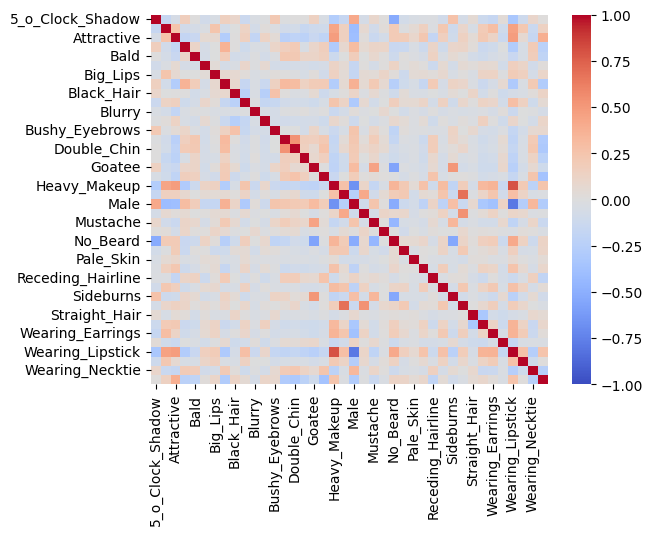

In [ ]:
corr_matrix = data.attributes.corr()
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()


In [ ]:
corr_values = corr_matrix['Heavy_Makeup'].abs().sort_values(ascending=False)
top_8_features = corr_values[1:9].index
print(top_8_features)

Index(['Wearing_Lipstick', 'Male', 'Attractive', 'Arched_Eyebrows',
       'Wearing_Earrings', 'No_Beard', 'Wavy_Hair', 'Rosy_Cheeks'],
      dtype='object')


In [ ]:
cols=['Wearing_Lipstick', 'Male', 'Attractive', 'Arched_Eyebrows',
       'Wearing_Earrings', 'No_Beard', 'Wavy_Hair', 'Rosy_Cheeks']

celeba = CelebA(selected_features=cols)


celeba
celeba.attributes

,Wearing_Lipstick,Male,Attractive,Arched_Eyebrows,Wearing_Earrings,No_Beard,Wavy_Hair,Rosy_Cheeks,image_id
image_id,,,,,,,,,
000001.jpg,1,0,1,1,1,1,0,0,000001.jpg
000002.jpg,0,0,0,0,0,1,0,0,000002.jpg
000003.jpg,0,1,0,0,0,1,1,0,000003.jpg
000004.jpg,1,0,1,0,1,1,0,0,000004.jpg
000005.jpg,1,0,1,1,0,1,0,0,000005.jpg
...,...,...,...,...,...,...,...,...,...
202595.jpg,1,0,1,0,0,1,0,0,202595.jpg
202596.jpg,0,1,0,0,0,1,0,0,202596.jpg
202597.jpg,0,1,0,0,0,1,0,0,202597.jpg


In [ ]:
celeba.features_name

['Wearing_Lipstick',
 'Male',
 'Attractive',
 'Arched_Eyebrows',
 'Wearing_Earrings',
 'No_Beard',
 'Wavy_Hair',
 'Rosy_Cheeks']

In [ ]:
# shows five random samples
celeba.attributes.sample(5)

,Wearing_Lipstick,Male,Attractive,Arched_Eyebrows,Wearing_Earrings,No_Beard,Wavy_Hair,Rosy_Cheeks,image_id
image_id,,,,,,,,,
082125.jpg,1,0,1,0,1,1,1,0,082125.jpg
117018.jpg,1,0,1,1,1,1,0,0,117018.jpg
050871.jpg,1,0,1,1,1,1,0,1,050871.jpg
125180.jpg,0,1,0,0,0,0,0,0,125180.jpg
103081.jpg,1,0,1,0,0,1,0,0,103081.jpg


In [ ]:
batch_size=16

In [ ]:
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset, Subset

class CelebADataset(Dataset):
    def __init__(self, dataframe, images_folder, transform=None):
        self.dataframe = dataframe
        self.images_folder = images_folder
        self.transform = transform

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        img_path = os.path.join(self.images_folder, row['image_id'])
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        label = row[celeba.features_name].values.astype('float32')
        label1=torch.tensor([label[0]])
        label2=torch.tensor([label[1]])
        label3=torch.tensor([label[2]])
        label4=torch.tensor([label[3]])
        label5=torch.tensor([label[4]])
        label6=torch.tensor([label[5]])
        label7=torch.tensor([label[6]])
        label8=torch.tensor([label[7]])

        return img, label1,label2,label3,label4,label5,label6,label7,label8

    def __len__(self):
        return len(self.dataframe)

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return tuple([d[index] for d in self.data])

    def __len__(self):
        return len(self.data[0])
# define transformations
transform_train = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
transform_valid = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# get training and validation set:
train_split = celeba.split('training'  , drop_zero=False)
valid_split = celeba.split('validation', drop_zero=False)
test_split = celeba.split('test', drop_zero=False)


# data loaders:
train_dataset = CelebADataset(train_split, celeba.images_folder, transform_train)
valid_dataset = CelebADataset(valid_split, celeba.images_folder, transform_valid)
test_dataset = CelebADataset(test_split, celeba.images_folder, transform_valid)

half_size_train = len(train_dataset) // 800
subset_indices_train = list(range(half_size_train))
train_split_half = Subset(train_dataset, subset_indices_train)

half_size_test = len(test_dataset) // 800
subset_indices_test = list(range(half_size_test))
test_split_half = Subset(test_dataset, subset_indices_test)

half_size_valid = len(valid_dataset) // 800
subset_indices_valid = list(range(half_size_valid))
valid_split_half = Subset(valid_dataset, subset_indices_valid)



train_loader = DataLoader(train_split_half, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_split_half, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_split_half, batch_size=batch_size, shuffle=False)

In [ ]:
for (j,k,l,m,n,o,q,r,s) in test_loader:
  print(j[0].shape,k[0],l[0],m[0],n[0],o[0])

torch.Size([3, 128, 128]) tensor([0.]) tensor([0.]) tensor([0.]) tensor([1.]) tensor([1.])
torch.Size([3, 128, 128]) tensor([1.]) tensor([0.]) tensor([0.]) tensor([1.]) tensor([1.])


In [ ]:
def accuracy(output, target):
    with torch.no_grad():
        predicted_labels = torch.round(torch.sigmoid(output))
        correct = (predicted_labels == target).sum().item()
        total = target.size(0)
        accuracy = correct / total

    return accuracy

Without DST

In [ ]:
import torch.optim as optim
import torchvision.models as models
class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        self.shared_layer = nn.Sequential(
            models.resnet18(pretrained=False)
        )

        self.task1_layer = nn.Linear(1000, 1)
        self.task2_layer = nn.Linear(1000, 1)
        self.task3_layer = nn.Linear(1000, 1)
        self.task4_layer = nn.Linear(1000, 1)
        self.task5_layer = nn.Linear(1000, 1)
        self.task6_layer = nn.Linear(1000, 1)
        self.task7_layer = nn.Linear(1000, 1)
        self.task8_layer = nn.Linear(1000, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.shared_layer(x)
        x = F.relu(x)
        out1 = self.sigmoid(self.task1_layer(x))
        out2 = self.sigmoid(self.task2_layer(x))
        out3 = self.sigmoid(self.task3_layer(x))
        out4 = self.sigmoid(self.task4_layer(x))
        out5 = self.sigmoid(self.task5_layer(x))
        out6 = self.sigmoid(self.task6_layer(x))
        out7 = self.sigmoid(self.task7_layer(x))
        out8 = self.sigmoid(self.task8_layer(x))
        return out1, out2, out3,out4,out5,out6,out7,out8
model = MultiTaskModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

# training loop
for epoch in range(5):
    # train
    model.train()
    train_loss = 0
    train_acc = [0] * 8
    for x, y1, y2, y3,y4,y5,y6,y7, y8 in train_loader:
        x, y1, y2, y3, y4, y5, y6, y7, y8 = x.to(device), y1.to(device), y2.to(device), y3.to(device), y4.to(device), y5.to(device), y6.to(device), y7.to(device), y8.to(device)
        optimizer.zero_grad()
        out1, out2, out3, out4, out5, out6, out7, out8 = model(x)
        out1=out1.to(device)
        out2=out2.to(device)
        out3=out3.to(device)
        out4=out4.to(device)
        out5=out5.to(device)
        out6=out6.to(device)
        out7=out7.to(device)
        out8=out8.to(device)

        loss1 = criterion(out1, y1.float())
        loss2 = criterion(out2, y2.float())
        loss3 = criterion(out3, y3.float())
        loss4 = criterion(out4, y4.float())
        loss5 = criterion(out5, y5.float())
        loss6 = criterion(out6, y6.float())
        loss7 = criterion(out7, y7.float())
        loss8 = criterion(out8, y8.float())
        loss = loss1 + loss2 + loss3+loss4+loss5+loss6+loss7 + loss8
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc[0] += accuracy(out1, y1)
        train_acc[1] += accuracy(out2, y2)
        train_acc[2] += accuracy(out3, y3)
        train_acc[3] += accuracy(out4, y4)
        train_acc[4] += accuracy(out5, y5)
        train_acc[5] += accuracy(out6, y6)
        train_acc[6] += accuracy(out7, y7)
        train_acc[7] += accuracy(out8, y8)
    train_loss /= len(train_loader)
    train_acc = [(a / len(train_loader))*100 for a in train_acc]
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.6f}, Train Acc = {train_acc}")



/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss = 5.404021, Train Acc = [51.31118881118881, 54.195804195804186, 47.24650349650349, 65.95279720279721, 73.16433566433567, 84.17832167832168, 68.0944055944056, 85.18356643356644]
Epoch 2: Train Loss = 5.325694, Train Acc = [50.34965034965035, 57.08041958041957, 45.061188811188806, 69.27447552447552, 79.58916083916083, 83.95979020979021, 73.42657342657343, 91.6083916083916]
Epoch 3: Train Loss = 5.321324, Train Acc = [49.91258741258741, 57.51748251748252, 44.624125874125866, 68.8374125874126, 79.37062937062937, 84.39685314685315, 73.86363636363636, 91.6083916083916]
Epoch 4: Train Loss = 5.323509, Train Acc = [49.91258741258741, 57.298951048951054, 45.061188811188806, 69.05594405594405, 79.37062937062937, 84.17832167832168, 73.86363636363636, 91.6083916083916]
Epoch 5: Train Loss = 5.325694, Train Acc = [50.34965034965035, 57.08041958041957, 44.84265734265734, 68.61888111888112, 79.15209790209789, 83.95979020979021, 74.08216783216784, 91.6083916083916]


In [ ]:

with torch.no_grad():
    # train
    model.eval()
    test_loss = 0
    test_acc = [0] * 8
    for x, y1, y2, y3,y4,y5,y6,y7, y8 in test_loader:
        x, y1, y2, y3, y4, y5, y6, y7, y8 = x.to(device), y1.to(device), y2.to(device), y3.to(device), y4.to(device), y5.to(device), y6.to(device), y7.to(device), y8.to(device)
        out1, out2, out3, out4, out5, out6, out7, out8 = model(x)
        out1=out1.to(device)
        out2=out2.to(device)
        out3=out3.to(device)
        out4=out4.to(device)
        out5=out5.to(device)
        out6=out6.to(device)
        out7=out7.to(device)
        out8=out8.to(device)
        loss1 = criterion(out1, y1.float())
        loss2 = criterion(out2, y2.float())
        loss3 = criterion(out3, y3.float())
        loss4 = criterion(out4, y4.float())
        loss5 = criterion(out5, y5.float())
        loss6 = criterion(out6, y6.float())
        loss7 = criterion(out7, y7.float())
        loss8 = criterion(out8, y8.float())
        loss = loss1 + loss2 + loss3+loss4+loss5+loss6+loss7 + loss8
        test_loss += loss.item()
        test_acc[0] += accuracy(out1, y1)
        test_acc[1] += accuracy(out2, y2)
        test_acc[2] += accuracy(out3, y3)
        test_acc[3] += accuracy(out4, y4)
        test_acc[4] += accuracy(out5, y5)
        test_acc[5] += accuracy(out6, y6)
        test_acc[6] += accuracy(out7, y7)
        test_acc[7] += accuracy(out8, y8)

    test_loss /= len(test_loader)
    test_acc = [(a / len(test_loader))*100 for a in test_acc]
    overall_acc = sum(test_acc) / len(test_acc)
    print(f"Epoch {epoch + 1}: Test Loss = {test_loss:.6f}, Test Acc = {test_acc}, Overall Acc = {overall_acc:.2f}")

Epoch 5: Test Loss = 5.629157, Test Acc = [46.875, 71.875, 37.5, 68.75, 68.75, 78.125, 62.5, 90.625], Overall Acc = 65.62


With DST

In [ ]:
import torch.optim as optim
import torchvision.models as models
import random
class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        self.shared_layer = nn.Sequential(

            models.resnet18(pretrained=False)
        )
        self.task1_layer = nn.Linear(1000, 1)
        self.task2_layer = nn.Linear(1000, 1)
        self.task3_layer = nn.Linear(1000, 1)
        self.task4_layer = nn.Linear(1000, 1)
        self.task5_layer = nn.Linear(1000, 1)
        self.task6_layer = nn.Linear(1000, 1)
        self.task7_layer = nn.Linear(1000, 1)
        self.task8_layer = nn.Linear(1000, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.shared_layer(x)
        x = F.relu(x)
        out1 = self.sigmoid(self.task1_layer(x))
        out2 = self.sigmoid(self.task2_layer(x))
        out3 = self.sigmoid(self.task3_layer(x))
        out4 = self.sigmoid(self.task4_layer(x))
        out5 = self.sigmoid(self.task5_layer(x))
        out6 = self.sigmoid(self.task6_layer(x))
        out7 = self.sigmoid(self.task7_layer(x))

        out8 = self.sigmoid(self.task8_layer(x))
        return out1, out2, out3,out4,out5,out6,out7,out8
model = MultiTaskModel().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()


# training loop
c=0
initial_losses=[]
lambda_u=0.5

for epoch in range(5):
    # train
    model.train()
    train_loss = 0
    train_acc = [0] * 8
    I_k_t = [0] * 8
    G = [1] * 8
    for x, y1, y2, y3,y4,y5,y6,y7, y8 in train_loader:
        x, y1, y2, y3, y4, y5, y6, y7, y8 = x.to(device), y1.to(device), y2.to(device), y3.to(device), y4.to(device), y5.to(device), y6.to(device), y7.to(device), y8.to(device)
        optimizer.zero_grad()
        out1, out2, out3, out4, out5, out6, out7, out8 = model(x)
        out1=out1.to(device)
        out2=out2.to(device)
        out3=out3.to(device)
        out4=out4.to(device)
        out5=out5.to(device)
        out6=out6.to(device)
        out7=out7.to(device)
        out8=out8.to(device)

        loss1 = criterion(out1, y1.float())
        loss2 = criterion(out2, y2.float())
        loss3 = criterion(out3, y3.float())
        loss4 = criterion(out4, y4.float())
        loss5 = criterion(out5, y5.float())
        loss6 = criterion(out6, y6.float())
        loss7 = criterion(out7, y7.float())
        loss8 = criterion(out8, y8.float())
        if c==0:
          initial_losses.append(loss1)
          initial_losses.append(loss2)
          initial_losses.append(loss3)
          initial_losses.append(loss4)
          initial_losses.append(loss5)
          initial_losses.append(loss6)
          initial_losses.append(loss7)
          initial_losses.append(loss8)
        loss=G[0]*loss1+G[1]*loss2+G[2]*loss3+G[3]*loss4+G[4]*loss5+G[5]*loss6+G[6]*loss7+G[7]*loss8
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        train_acc[0] += accuracy(out1, y1)
        train_acc[1] += accuracy(out2, y2)
        train_acc[2] += accuracy(out3, y3)
        train_acc[3] += accuracy(out4, y4)
        train_acc[4] += accuracy(out5, y5)
        train_acc[5] += accuracy(out6, y6)
        train_acc[6] += accuracy(out7, y7)
        train_acc[7] += accuracy(out8, y8)

        I_k_t[0] = loss1/initial_losses[0]
        I_k_t[1] = loss2/initial_losses[1]
        I_k_t[2] = loss3/initial_losses[2]
        I_k_t[3] = loss4/initial_losses[3]
        I_k_t[4] = loss5/initial_losses[4]
        I_k_t[5] = loss6/initial_losses[5]
        I_k_t[6] = loss7/initial_losses[6]
        I_k_t[7] = loss8/initial_losses[7]

    vector_sum = sum(I_k_t)

    P_I_k_t = [1/8 for element in I_k_t]

    expected_value = sum([x * p for x, p in zip(I_k_t, P_I_k_t)])

    P_u_k_t = [min(1,(I_k_t[i]/expected_value).item()) for i in range(8)]

    activation_prob= [lambda_u*i+1-lambda_u*1 for i in P_u_k_t]
    G = [1 if random.random() < p else 0 for p in activation_prob]

    c+=1
    train_loss /= len(train_loader)
    train_acc = [(a / len(train_loader))*100 for a in train_acc]
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.6f}, Train Acc = {train_acc}","Drop Rates = ",P_u_k_t)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss = 4.732897, Train Acc = [50.43706293706294, 55.069930069930074, 55.59440559440559, 63.59265734265735, 72.46503496503496, 84.61538461538461, 68.31293706293707, 12.237762237762237] Drop Rates =  [1, 1, 1, 1, 1, 0.6307048797607422, 0.9104494452476501, 0.9066066741943359]
Epoch 2: Train Loss = 4.918513, Train Acc = [50.56818181818182, 56.861888111888106, 55.37587412587413, 69.05594405594405, 79.58916083916083, 84.17832167832168, 74.08216783216784, 86.80069930069929] Drop Rates =  [1, 0.9839181900024414, 1, 0.9929059743881226, 0.9928615093231201, 0.9444177746772766, 0.8626325726509094, 0.8553162217140198]
Epoch 3: Train Loss = 5.389865, Train Acc = [50.34965034965035, 57.08041958041957, 55.15734265734265, 69.27447552447552, 79.37062937062937, 84.39685314685315, 73.86363636363636, 91.82692307692307] Drop Rates =  [1, 0.96773761510849, 1, 0.9765775799751282, 0.976533830165863, 0.7583198547363281, 0.8484465479850769, 0.841250479221344]
Epoch 4: Train Loss = 4.696717, Train 

In [ ]:

with torch.no_grad():
    # train
    model.eval()
    test_loss = 0
    test_acc = [0] * 8
    for x, y1, y2, y3,y4,y5,y6,y7, y8 in test_loader:
        x, y1, y2, y3, y4, y5, y6, y7, y8 = x.to(device), y1.to(device), y2.to(device), y3.to(device), y4.to(device), y5.to(device), y6.to(device), y7.to(device), y8.to(device)
        out1, out2, out3, out4, out5, out6, out7, out8 = model(x)
        out1=out1.to(device)
        out2=out2.to(device)
        out3=out3.to(device)
        out4=out4.to(device)
        out5=out5.to(device)
        out6=out6.to(device)
        out7=out7.to(device)
        out8=out8.to(device)
        loss1 = criterion(out1, y1.float())
        loss2 = criterion(out2, y2.float())
        loss3 = criterion(out3, y3.float())
        loss4 = criterion(out4, y4.float())
        loss5 = criterion(out5, y5.float())
        loss6 = criterion(out6, y6.float())
        loss7 = criterion(out7, y7.float())
        loss8 = criterion(out8, y8.float())
        loss = loss1 + loss2 + loss3+loss4+loss5+loss6+loss7 + loss8
        test_loss += loss.item()
        test_acc[0] += accuracy(out1, y1)
        test_acc[1] += accuracy(out2, y2)
        test_acc[2] += accuracy(out3, y3)
        test_acc[3] += accuracy(out4, y4)
        test_acc[4] += accuracy(out5, y5)
        test_acc[5] += accuracy(out6, y6)
        test_acc[6] += accuracy(out7, y7)
        test_acc[7] += accuracy(out8, y8)

    test_loss /= len(test_loader)
    test_acc = [(a / len(test_loader))*100 for a in test_acc]
    overall_acc = sum(test_acc) / len(test_acc)
    print(f"Epoch {epoch + 1}: Test Loss = {test_loss:.6f}, Test Acc = {test_acc}, Overall Acc = {overall_acc:.2f}")

Epoch 5: Test Loss = 5.384042, Test Acc = [46.875, 71.875, 62.5, 68.75, 68.75, 78.125, 62.5, 90.625], Overall Acc = 68.75
